# Import Libraries

In [ ]:
import os
import cv2
import numpy as np
from glob import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
!pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, cohen_kappa_score, confusion_matrix, accuracy_score
import time
inicio = time.time()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import sys

FOLDER = '/content/drive/My Drive/DATA_LINDEROS/'
sys.path.append(FOLDER)


Mounted at /content/drive


# Preprocessing

In [ ]:
IMAGE_PATH = '/content/drive/MyDrive/DATA_LINDEROS/DATASET_Tabio/Ortofoto_256x256/'
MASK_PATH = '/content/drive/MyDrive/DATA_LINDEROS/DATASET_Tabio/Linderos_256x256/'
batch_size = 8

#!ls '/content/drive/My Drive/DATA_LINDEROS/LINDEROS/'
import os
contenido = os.listdir('/content/drive/MyDrive/DATA_LINDEROS/DATASET_Tabio/Linderos_256x256/')
print(len(contenido))

#!ls '/content/drive/My Drive/DATA_LINDEROS/ORTOFOTO/'
contenido = os.listdir('/content/drive/MyDrive/DATA_LINDEROS/DATASET_Tabio/Ortofoto_256x256/')
print(len(contenido))


18278
18278


# Dataset

In [ ]:
class SegmentationDataset(Dataset):

  def __init__(self, img_paths:list, mask_paths:list, transform=None):
    self.img_paths = img_paths
    self.mask_paths = mask_paths
    self.transform = transform

  def __len__(self):
    return len(self.img_paths)

  def __getitem__(self, index):
    image = cv2.imread(self.img_paths[index])
    if image is None:
        print(f"Error: Could not read image file: {self.img_paths[index]}")
        return None, None

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype('float32') / 255.0

    mask = cv2.imread(self.mask_paths[index], cv2.IMREAD_GRAYSCALE)
    if mask is None:
        print(f"Error: Could not read mask file: {self.mask_paths[index]}")
        return None, None

    mask = mask.astype('float32') / 255.0
    mask[mask > 0] = 1


    image = cv2.resize(image, (512, 512))
    mask = cv2.resize(mask, (512, 512))

    if image.shape[:2] != mask.shape:
      print(f"Error: Image and mask shapes do not match after resizing: {self.img_paths[index]}, {self.mask_paths[index]}")
      return None, None

    original_height, original_width = image.shape[:2]

    h, w = image.shape[:2]
    new_h = (h // 32 + 1) * 32
    new_w = (w // 32 + 1) * 32

    image = cv2.copyMakeBorder(image, 0, max(0, new_h - h), 0, max(0, new_w - w), cv2.BORDER_CONSTANT, value=0)
    mask = cv2.copyMakeBorder(mask, 0, max(0, new_h - h), 0, max(0, new_w - w), cv2.BORDER_CONSTANT, value=0) # Pad the mask as well

    image = image[:original_height, :original_width]
    mask = mask[:original_height, :original_width]


    image = torch.tensor(image).permute(2,0,1)
    mask = torch.tensor(mask).unsqueeze(0)

    return image, mask


image_paths = sorted(glob(os.path.join(IMAGE_PATH, '*.TIF')))
mask_paths = sorted(glob(os.path.join(MASK_PATH, '*.TIF')))

train_images,val_images, train_mask, val_mask = train_test_split(image_paths,
                                                                 mask_paths,
                                                                 test_size=0.2,
                                                                 random_state=42
                                                                 )

train_dataset = SegmentationDataset(train_images, train_mask)
val_dataset = SegmentationDataset(val_images, val_mask)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Número de imágenes de entrenamiento: {len(train_dataset)}")
print(f"Número de imágenes de validación: {len(val_dataset)}")

Número de imágenes de entrenamiento: 14622
Número de imágenes de validación: 3656


In [ ]:
img, mask = train_dataset [0]

In [ ]:
img.size(), mask.size()

(torch.Size([3, 512, 512]), torch.Size([1, 512, 512]))

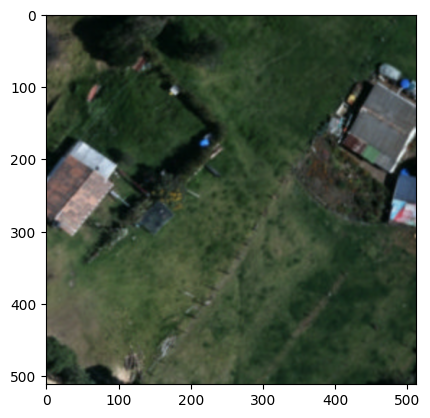

In [ ]:
plt.imshow(img.permute(1, 2, 0).cpu().numpy())

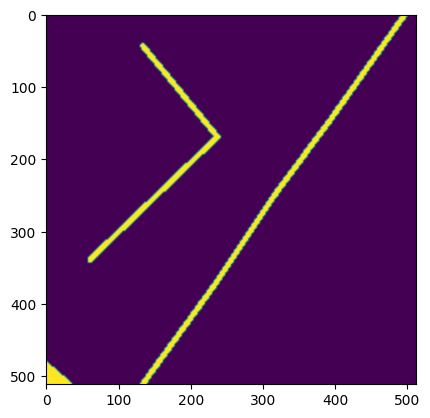

In [ ]:
plt.imshow(mask.permute(1,2,0))

In [ ]:
# Función para calcular el puntaje F1 para la clase "lindero"
def calcular_f1_lindero(predicciones, mascaras):
    """Calcula el puntaje F1 para la clase 'lindero'.

    Args:
        predicciones: Tensor de predicciones del modelo.
        mascaras: Tensor de máscaras verdaderas.

    Returns:
        Puntaje F1 para la clase 'lindero'.
    """


    # Convierte las predicciones a etiquetas binarias (0 o 1)
    predicciones_binarias = (predicciones > 0.5).astype(int)

    # Calcula el puntaje F1 usando sklearn.metrics.f1_score
    f1 = f1_score(mascaras.flatten(), predicciones_binarias.flatten())

    return f1

# Model

In [ ]:
model = smp.FPN(encoder_name='resnet34', encoder_weights='imagenet', in_channels=3, classes=1)
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
model

FPN(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

# Training

In [ ]:
mejor_f1_lindero = 0
epochs = 7
all_predictions = []
all_masks = []
memory_predictions_last_epoch = []  # Store predictions only for the last epoch
memory_masks_last_epoch = []  # Store masks only for the last epoch

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_cm = np.zeros((2, 2), dtype=np.int64)
    train_accuracy = 0.0
    train_f1_boundary = 0.0
    train_f1_no_boundary = 0.0
    train_kappa = 0.0

    for images,mask in train_loader:
        images, mask = images.to(device), mask.to(device)

        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, mask)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        output_binary = (torch.sigmoid(output) > 0.5).cpu().numpy().astype(np.uint8)
        mask_binary = mask.cpu().numpy().astype(np.uint8)
        train_cm += confusion_matrix(mask_binary.flatten(), output_binary.flatten())
        train_accuracy += accuracy_score(mask_binary.flatten(), output_binary.flatten())
        train_f1_boundary += f1_score(mask_binary.flatten(), output_binary.flatten(), pos_label=1)
        train_f1_no_boundary += f1_score(mask_binary.flatten(), output_binary.flatten(), pos_label=0)
        train_kappa += cohen_kappa_score(mask_binary.flatten(), output_binary.flatten())

    torch.cuda.empty_cache()

    model.eval()
    val_loss = 0.0
    # Métricas para la validación
    val_cm = np.zeros((2, 2), dtype=np.int64)  # Inicializar matriz de confusión
    val_accuracy = 0.0
    val_f1_boundary = 0.0
    val_f1_no_boundary = 0.0
    val_kappa = 0.0

    with  torch.no_grad():
        for images, mask in val_loader:
            images, mask = images.to(device), mask.to(device)
            output = model(images)
            loss = criterion(output, mask)
            val_loss += loss.item()

            output_binary = (torch.sigmoid(output) > 0.5).cpu().numpy().astype(np.uint8)
            all_predictions.extend(output_binary)
            mask_binary = mask.cpu().numpy().astype(np.uint8)
            all_masks.extend(mask_binary) # Guardar las máscaras originales para imprimir
            val_cm += confusion_matrix(mask_binary.flatten(), output_binary.flatten())
            val_accuracy += accuracy_score(mask_binary.flatten(), output_binary.flatten())
            val_f1_boundary += f1_score(mask_binary.flatten(), output_binary.flatten(), pos_label=1)
            val_f1_no_boundary += f1_score(mask_binary.flatten(), output_binary.flatten(), pos_label=0)
            val_kappa += cohen_kappa_score(mask_binary.flatten(), output_binary.flatten())

            # Guardar predicciones y máscaras solo en la última época
            if epoch == epochs - 1:
                output_binary = (torch.sigmoid(output) > 0.5).cpu().numpy().astype(np.uint8)
                mask_binary = mask.cpu().numpy().astype(np.uint8)

                for j in range(output_binary.shape[0]):
                    memory_predictions_last_epoch.append(output_binary[j])
                    memory_masks_last_epoch.append(mask_binary[j])

    train_loss = train_loss / len(train_loader)
    train_accuracy = train_accuracy / len(train_loader)
    train_f1_boundary = train_f1_boundary / len(train_loader)
    train_f1_no_boundary = train_f1_no_boundary / len(train_loader)
    train_kappa = train_kappa / len(train_loader)

    val_loss = val_loss / len(val_loader)
    val_accuracy = val_accuracy / len(val_loader)
    val_f1_boundary = val_f1_boundary / len(val_loader)
    val_f1_no_boundary = val_f1_no_boundary / len(val_loader)
    val_kappa = val_kappa / len(val_loader)

        # Calcula el puntaje F1 para la clase "lindero"
    f1_lindero = calcular_f1_lindero(output_binary, mask_binary)

        # Guarda el modelo si el puntaje F1 es mayor que el mejor hasta ahora
    if f1_lindero > mejor_f1_lindero:
        mejor_f1_lindero = f1_lindero
        torch.save(model.state_dict(), 'best_model104.pth')
        print(f"Model saved at epoch {epoch + 1} with f1 socore boundary: {mejor_f1_lindero:.4f}")

    print(f"Epoch [{epoch + 1}/{epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Train F1 Boundary: {train_f1_boundary:.4f}, Train F1 No Boundary: {train_f1_no_boundary:.4f}, Train Kappa: {train_kappa:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Val F1 Boundary: {val_f1_boundary:.4f}, Val F1 No Boundary: {val_f1_no_boundary:.4f}, Val Kappa: {val_kappa:.4f}")
    print(f"Train Confusion Matrix:\n{train_cm}")
    print(f"Validation Confusion Matrix:\n{val_cm}")

# Mostrar todas las máscaras y predicciones para comparación solo de la ultima epoca
if memory_predictions_last_epoch and memory_masks_last_epoch:
    print("Mostrando máscaras y predicciones para comparación de la ultima época...")
    for i, (predicted_mask, mask_original) in enumerate(zip(memory_predictions_last_epoch, memory_masks_last_epoch)):
        plt.figure(figsize=(10, 5))

        # Mostrar máscara original
        plt.subplot(1, 2, 1)
        plt.imshow(mask_original.squeeze(), cmap='gray') # Squeeze to remove extra dimension
        plt.title(f"Máscara Original {i+1}")
        plt.axis('off')

        # Mostrar máscara predicha
        plt.subplot(1, 2, 2)
        plt.imshow(predicted_mask.squeeze(), cmap='gray') # Squeeze to remove extra dimension
        plt.title(f"Máscara Predicha {i+1}")
        plt.axis('off')

        plt.show()
else:
    print("No se encontraron imágenes para mostrar.")

Model saved at epoch 1 with f1 socore boundary: 0.6160
Epoch [1/7] - Train Loss: 0.1465, Train Acc: 0.9612, Train F1 Boundary: 0.3909, Train F1 No Boundary: 0.9798, Train Kappa: 0.3755, Val Loss: 0.1208, Val Acc: 0.9649, Val F1 Boundary: 0.5129, Val F1 No Boundary: 0.9817, Val Kappa: 0.4957
Train Confusion Matrix:
[[3630024863   28197568]
 [ 120544475   54302662]]
Validation Confusion Matrix:
[[904605258  10408406]
 [ 23251279  20133521]]
Model saved at epoch 2 with f1 socore boundary: 0.6368
Epoch [2/7] - Train Loss: 0.1216, Train Acc: 0.9654, Train F1 Boundary: 0.5014, Train F1 No Boundary: 0.9820, Train Kappa: 0.4852, Val Loss: 0.1156, Val Acc: 0.9640, Val F1 Boundary: 0.5548, Val F1 No Boundary: 0.9811, Val Kappa: 0.5363
Train Confusion Matrix:
[[3626149456   32072975]
 [ 100563562   74283575]]
Validation Confusion Matrix:
[[900183726  14829938]
 [ 19675452  23709348]]
Model saved at epoch 3 with f1 socore boundary: 0.6662
Epoch [3/7] - Train Loss: 0.1158, Train Acc: 0.9665, Train 

# Inference

In [ ]:
def infer_and_visualize(model, image_paths, device):
    for index, image_path in enumerate(image_paths): # Use enumerate to get index
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original_image = image.copy()
        image = image.astype('float32') / 255.0

        h, w = image.shape[:2]
        new_h = (h // 32 + 1) * 32
        new_w = (w // 32 + 1) * 32

        image = cv2.copyMakeBorder(image, 0, new_h - h, 0, new_w - w, cv2.BORDER_CONSTANT, value=0)

        image_tensor = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(image_tensor)
            output = torch.sigmoid(output).cpu().squeeze().numpy()
            output = (output > 0.5).astype(np.uint8)

            output = output[:original_image.shape[0], :original_image.shape[1]]

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.title(f'Imagen original {index + 1}') # Add index to title
        plt.imshow(original_image)

        plt.subplot(1, 3, 2)
        plt.title(f'Mascara {index + 1}') # Add index to title
        plt.imshow(output)

        plt.subplot(1, 3, 3)
        plt.title(f'Superposición {index + 1}') # Add index to title
        plt.imshow(original_image)
        plt.imshow(output, cmap='jet', alpha=0.5)

        plt.show()

In [ ]:
model.load_state_dict(torch.load("/content/best_model104.pth"))

<ipython-input-14-68c39673faad>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/best_model104.pth"))


<All keys matched successfully>

In [ ]:
model.eval()

FPN(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

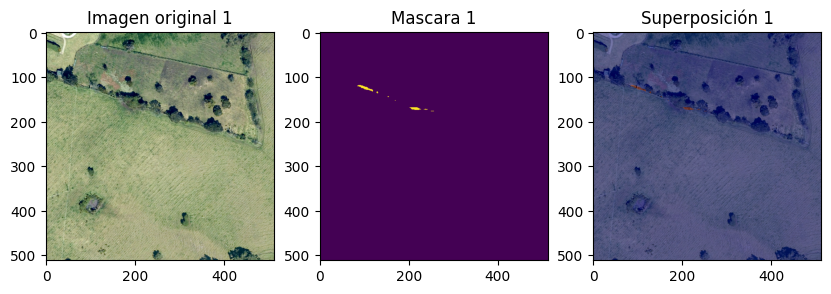

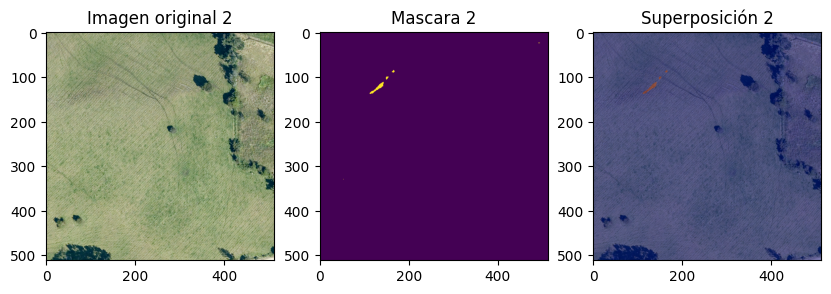

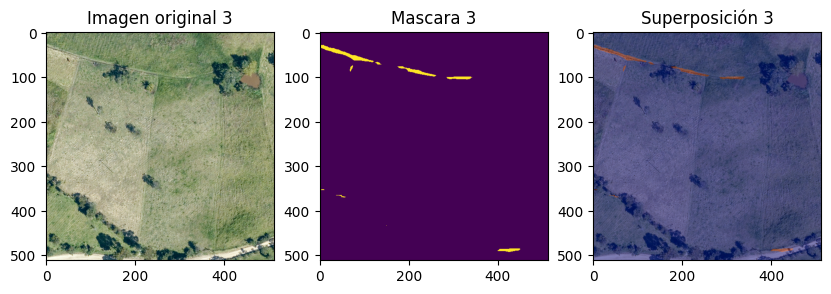

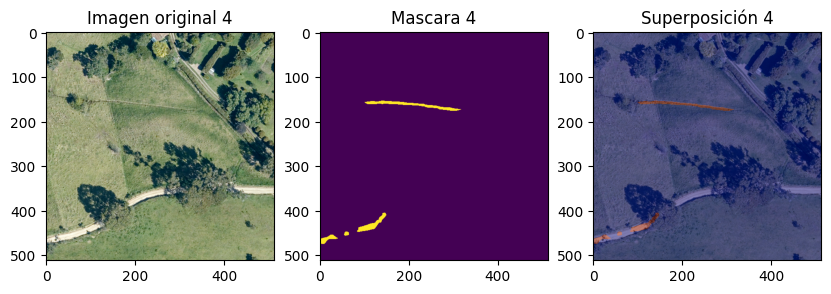

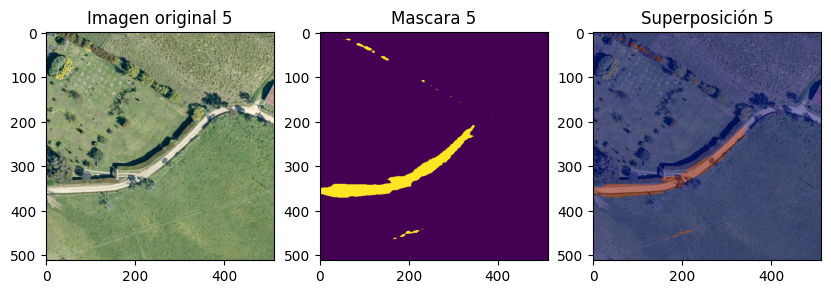

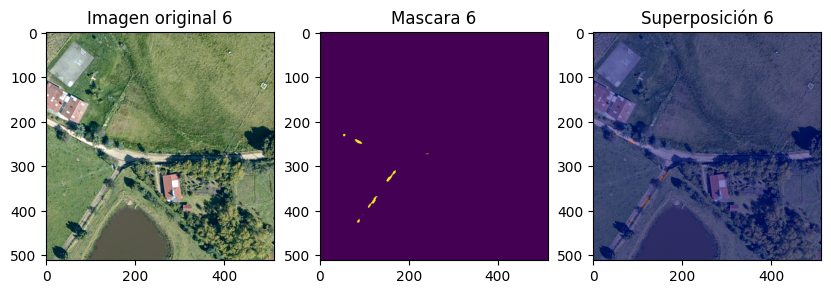

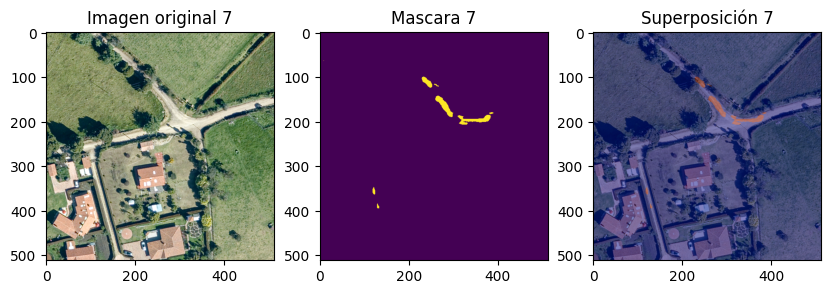

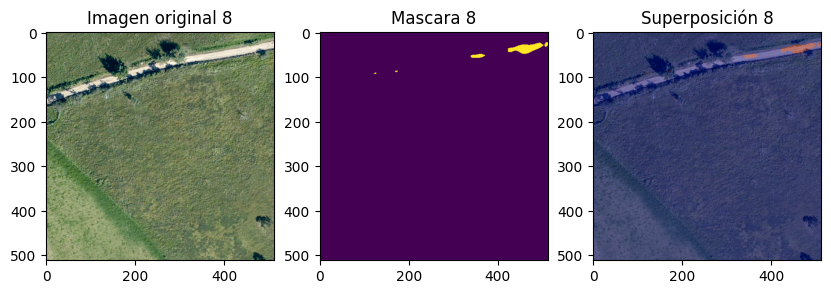

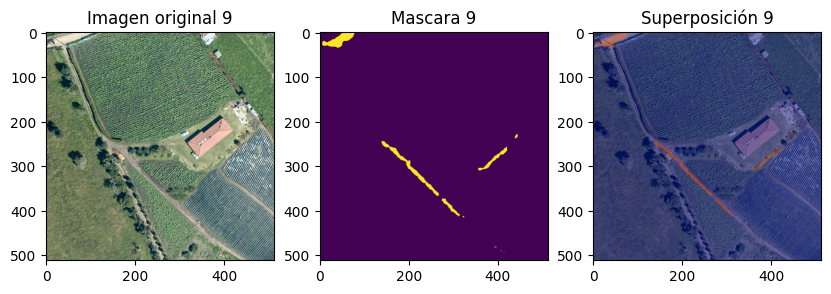

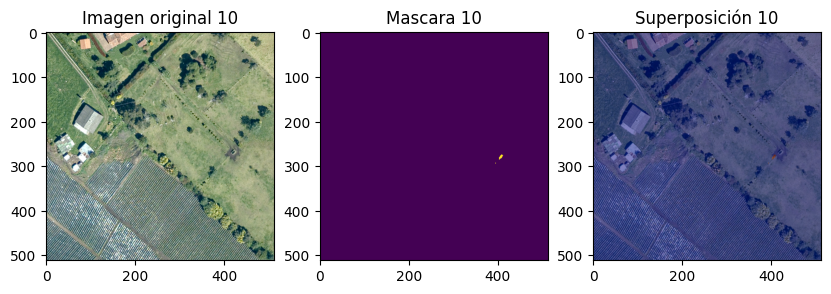

In [ ]:
IMAGE_PATH = '/content/drive/MyDrive/DATA_LINDEROS/DATASET_Subachoque/Ortofoto_512x512/'
MASK_PATH = '/content/drive/MyDrive/DATA_LINDEROS/DATASET_Subachoque/Linderos_512x512/'

inference_image_numbers = ['10028','10029','10030','10031','10032','10033','10034','10035','10036','10037']
images_list = [os.path.join(IMAGE_PATH, f'SUBACHOQUE_ORTO_{number}.TIF') for number in inference_image_numbers]

infer_and_visualize(model, images_list, device)

In [ ]:
import datetime

print(f"Hora de inicio: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


print(f"Hora de finalización: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Hora de inicio: 2025-01-26 13:14:55
Hora de finalización: 2025-01-26 13:14:55


In [ ]:
from google.colab import files

files.download('best_model104.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
fin = time.time()
tiempo_total = fin - inicio

# Convertir segundos a horas
horas = tiempo_total / 3600  # 3600 segundos en una hora

print(f"Tiempo total de ejecución: {horas} horas")

Tiempo total de ejecución: 0.03407162374920315 horas
